### Candidate number: 1030
***
## Exercise 6

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

In [217]:
class StockData:
    def __init__(self, tickers, start, end, names, period='11Y'):
        self.tickers = tickers
        self.names = {self.tickers[i]: names[i] for i in range(len(tickers))}
        self.df = yf.download(self.tickers, period=period, ignore_tz=True, progress=False)
        self.close = pd.DataFrame(self.df['Adj Close']).loc['2013-01-01':'2023-01-01']
        self.returns = np.log(self.close/self.close.shift()).dropna()

# Ticker symbols:
tickers = ['EQNR.OL', 'DNB.OL', 'MOWI.OL', 'KOG.OL', 'AKRBP.OL']
# Stock names:
stock_names = ['Equinor', 'DNB', 'MOWI', 'Kongsberg Gruppen', 'Aker BP']
# Stock data:
data = StockData(tickers, '2013-01-01', '2023-05-31', names=stock_names)

# Function which returns portfolio weights based on random uniform distribution draw of first entry
def weight_draw():
    equinor_weight = np.random.uniform(0, 1)
    other_weights = (1 - equinor_weight)/(len(tickers) - 1)
    return np.array([equinor_weight, other_weights, other_weights, other_weights, other_weights])

The first calculation below uses mean and correlation of the whole dataset to calculate an efficient frontier, optimal portfolio and create a capital market line with an assumed risk free rate of 2.5%. The second calculation estimates a rolling optimal portfolio where Equinor share and sharpe ratio is plotted from the last 252 days.

,Optimal portfolio weights:
Equinor,0.342908
DNB,0.164273
MOWI,0.164273
Kongsberg Gruppen,0.164273
Aker BP,0.164273


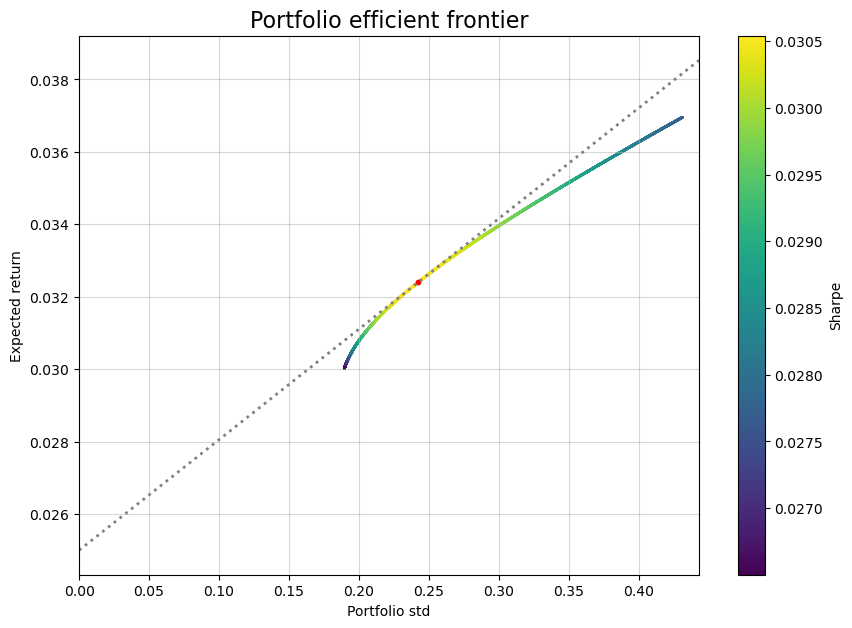

In [220]:

results = pd.DataFrame(columns=['Mean', 'Std', 'Sharpe'])
optimal_weights = pd.DataFrame(columns=tickers)
max_sharpe = 0

# Risk free rate
risk_free = 0.025

# Annual return mean
data_mean = data.returns.mean() * 252
data_cov = data.returns.cov() * 252

# Simmulation
for i in range(10000):
    weights = weight_draw()
    mean = (data_mean * weights).mean()                         # Expected portfolio return 
    std = np.sqrt(np.dot(weights.T, np.dot(data_cov, weights))) # Portfolio standard deviation
    sharpe = (mean - risk_free)/std
    # Check if sharpe ratio is the highest
    if sharpe > max_sharpe:
        max_sharpe = sharpe
        optimal_weights.loc[0] = weights

    results.loc[len(results)] = [mean, std, sharpe]

    
fig, ax1 = plt.subplots(1, figsize=(10,7))

results.plot(kind='scatter', x='Std', y='Mean', c='Sharpe', s=1, ax=ax1, xlabel='Portfolio std', ylabel='Expected return')
max_point = results['Sharpe'].idxmax()
sharpe_x, sharpe_y = results['Std'][max_point], results['Mean'][max_point]
ax1.scatter(sharpe_x, sharpe_y, color='red', s=10)
ax1.set_xlim(left=0)

x_vals = np.array(ax1.get_xlim())
y_vals = risk_free + results['Sharpe'].max() * x_vals
ax1.plot(x_vals, y_vals, ':', linewidth=2, color='gray')
ax1.grid(alpha=0.5);
ax1.set_title('Portfolio efficient frontier', fontsize=16)

display(optimal_weights.rename({0:'Optimal portfolio weights:'}).T.rename(data.names))

The optimal portfolio weights can be determined by simmulating different portfolio weights, then finding the weights with the highest Sharpe ratio, which is a measure of risk-adjusted return.

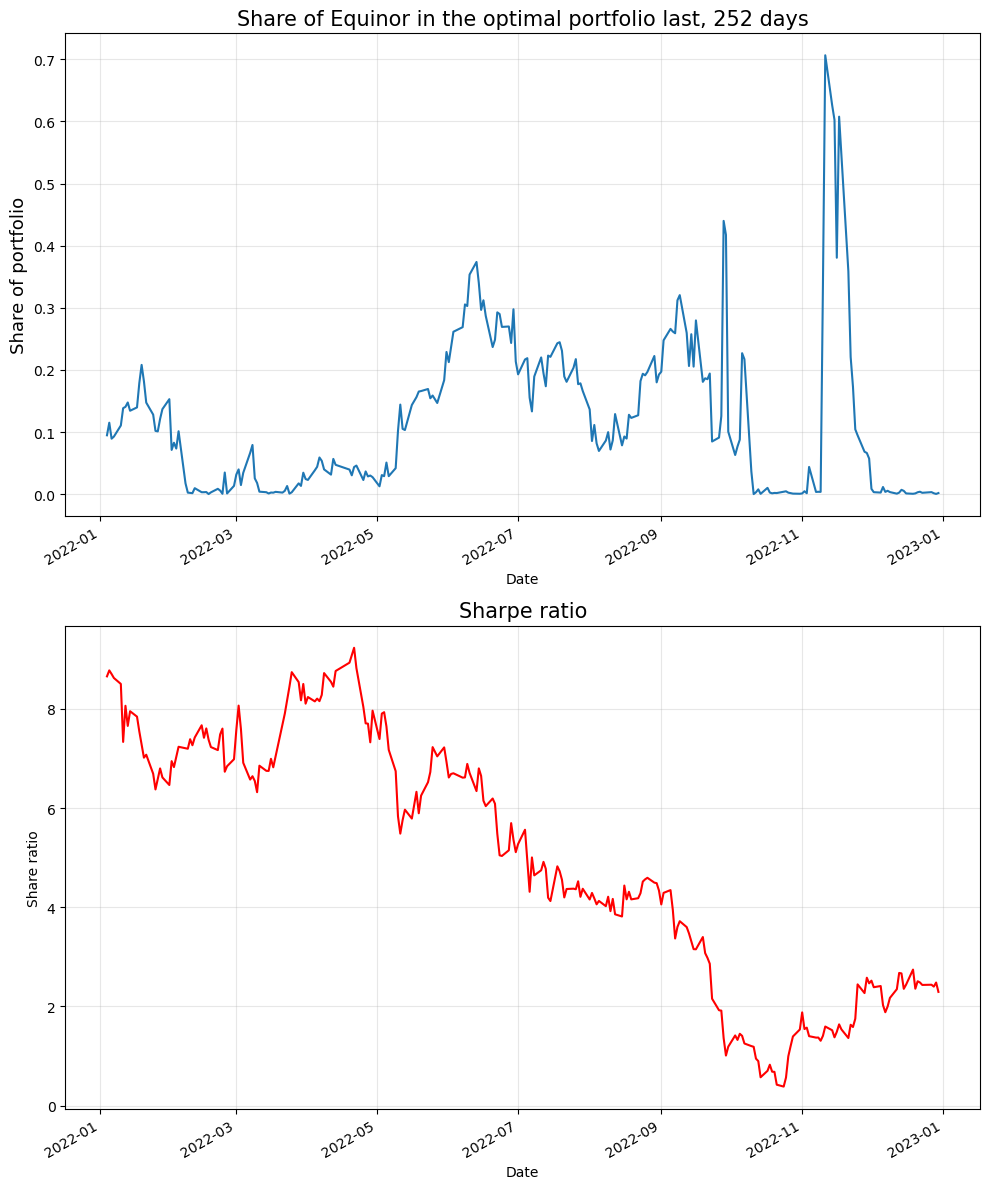

In [216]:
# The sharpe ratio is calculated with an assumed risk free rate of 0 for simpler calculations.

# Monte carlo simmulation with 300 simmulations
def sim_weights(data_mean, data_cov, Nsim=300):
    optimal_weight = []
    max_sharpe = 0
    for i in range(Nsim):
        weights = weight_draw()                                     # Drawing portfolio weights from function
        mean = (data_mean * weights).mean()                         # Calculating portfolio expected return
        std = np.sqrt(np.dot(weights.T, np.dot(data_cov, weights))) # Calculating portfolio standard deviation
        sharpe = mean/std                             # Calculating sharpe ratio

        # Finding optimal portfolio weights based on highest sharpe ratio
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            optimal_weight = weights

    # Return optimal portfolio weights
    return optimal_weight, max_sharpe

# Rolling mean calculation
rolling_mean = data.returns.rolling(252).sum().iloc[-252:]
optimal_weights = pd.DataFrame(columns=tickers)
equinor_share = []
highest_sharpe = []

for i in range(252):
    # Rolling mean
    mean = rolling_mean.iloc[i]
    # Rolling covariance
    cov = data.returns.iloc[-2*252 + i:-252+i].cov().to_numpy()    
    # Append optimal weight
    OW, HS = sim_weights(mean, cov)
    equinor_share.append(OW[0]) # Equinor share
    highest_sharpe.append(HS)

# Create result dataframe
results = pd.DataFrame({'Share':equinor_share, 'Sharpe':highest_sharpe}, index=data.returns.tail(252).index)

# Plot Equinor portfolio share
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,12))
results['Share'].plot(ax=ax1)
ax1.set_title('Share of Equinor in the optimal portfolio last, 252 days', fontsize=15)
ax1.set_ylabel('Share of portfolio', fontsize=13)
ax1.grid(alpha=0.3)
# Plot sharpe ratio
results['Sharpe'].plot(ax=ax2, color='red')
ax2.set_title('Sharpe ratio', fontsize=15)
ax2.grid(alpha=0.3)
ax2.set_ylabel('Share ratio')
fig.tight_layout()


#### Discussion
The plot shows us the portfolio weight of equinor stocks in the optimal portfolio each day for the last year. The optimal portfolio was calculated with the rolling mean and covariance from the previous 252 data points prior to the date of optimal portfolio weight distributions.

In tha last few months, Equinor share of the portfolio have been more or less zero, besides the sharp spike which went up to over 0.7.

The Sharpe ratio of the optimal portfolio has been stagnating for the past year, but seem to be rising the last months. The periods of highest Sharpe rations (best risk/return tradeoff) has been periods where Equinor share has been low.